---
# Model S - Data Augmentation and L2 Regularization with RMSprop Optimizer
- **32 x 32 x 3** Image size.
- **64** Batch size.
- Adaptive Moment Estimation **(Adam)** optimizer.
- **0.001** Initial Learning rate.
- **Sparse Categorical Cross-Entropy** loss function.
- **Reduce Learning Rate on Plateau** callback with a **0.1** factor and **3** patience.
- **Early Stopping** callback with **6** patience.
- **Model Checkpoint** callback to save the best model based on validation loss.
- **Data Augmentation Pipeline**
    - Random **Horizontal** Flip
    - Random Rotation **5%**
    - Random Zoom **5%**
    - Random Contrast **5%**
    - Random Brightness **5%**
- 3 **Convolutional** blocks with 2 layers each of **32**, **64** and **128** filters, with **ReLU** activation.
- **Batch Normalization** after each Convolutional layer.
- 3 **MaxPooling** layers with **2 x 2** pool size.
- **3 x 3** Convolutional kernel size.
- **Padding** is **valid**, in this case **1**.
- **4 x 4 x 128** Tensor before the **Flatten** layer.
- **256** Dense layer with **ReLU** activation.
- **10** Dense output layer with **Softmax** activation.
- **Dropout** layers with **0.5** rate after the Flatten and Dense layers.
- **L2** regularization with **0.0001** rate on the Dense layers and **0.00001** rate on the Convolutional layers.
- **815 018** Trainable Parameters.
- **30** Epochs.

---
#### Imports and Setup

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
print(f'TensorFlow version: {tf.__version__}')
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(3)
import matplotlib.pyplot as plt
import pickle
import numpy as np
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow import keras
from tensorflow.keras import callbacks, layers, optimizers, models
from keras import regularizers
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay ,accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

TensorFlow version: 2.15.0


---
#### Group Datasets

In [2]:
train_dirs = ['../data/train1', '../data/train3', '../data/train4', '../data/train5']
validation_dir = '../data/train2'
test_dir = '../data/test'

---
#### Create Datasets

In [3]:
IMG_SIZE = 32
BATCH_SIZE = 64
NUM_CLASSES = 10

train_datasets = [image_dataset_from_directory(directory, image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE) for directory in train_dirs]

train_dataset = train_datasets[0]
for dataset in train_datasets[1:]:
    train_dataset = train_dataset.concatenate(dataset)

train_dataset = train_dataset.shuffle(buffer_size=1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = image_dataset_from_directory(validation_dir, image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = image_dataset_from_directory(test_dir, image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

class_names = train_datasets[0].class_names

for data_batch, labels_batch in train_dataset.take(1):
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)

Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
data batch shape: (64, 32, 32, 3)
labels batch shape: (64,)


- We define the image size of 32 x 32 x 3, batch size of 64 and create an array with the label's names.  
- We create the train dataset by concatenating them, we **shuffle** the samples before each epoch and **prefetch** them to memory.  
- We do the same for the validation and test dataset except **shuffling** which is **unwanted** for these datasets.

---
#### Data Augmentation Pipeline

In [4]:
data_augmentation = keras.Sequential(
    [
        # keras.layers.RandomCrop(height=16, width=16), # This layer is commented out because it is not compatible with the current model architecture.
        keras.layers.RandomFlip("horizontal"),
        # keras.layers.RandomTranslation(0.1, 0.1), # This layer is commented out because it didn't improve the model performance.
        keras.layers.RandomRotation(0.05),
        keras.layers.RandomZoom(0.05),
        keras.layers.RandomContrast(0.05),
        keras.layers.RandomBrightness(0.05),
    ]
)

- **We define a data augmentation pipeline to apply to the images**.
- **The pipeline:**
    - Applies horizontal flipping to a random 50% of the images that go through it.
    - Randomly adjusts the contrast of the input images by 5%.
    - Randomly adjusts the brightness of the input images by 5%.
    - Randomly rotates the input images by 5%.
    - Randomly zooms the input images by 5%.

- **The following techniques were tested but the model didn't perform well:**
    - RandomCrop: Randomly crops the images along the width and height down to 16 x 16.
    - Randomly translates the input images along the width and height by 10%.
- **We also didn't find any custom augmentation techniques that improved the model performance**.

---
#### Model Architecture

In [5]:
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu", kernel_regularizer=regularizers.L2(1e-5), padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu", kernel_regularizer=regularizers.L2(1e-5), padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu", kernel_regularizer=regularizers.L2(1e-5), padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu", kernel_regularizer=regularizers.L2(1e-5), padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu", kernel_regularizer=regularizers.L2(1e-5), padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu", kernel_regularizer=regularizers.L2(1e-5), padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation="relu", kernel_regularizer=regularizers.L2(1e-4))(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax", kernel_regularizer=regularizers.L2(1e-4))(x)
model = models.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 32, 32, 3)         0         
                                                                 
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                             

---
#### Model Compilation

In [6]:
initial_learning_rate = 0.001
optimizer = optimizers.Adam(learning_rate=initial_learning_rate)
loss_function = keras.losses.SparseCategoricalCrossentropy()

lr_scheduler = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)
save_best_model = callbacks.ModelCheckpoint(filepath='../models/03_model_s_data_augm_l2_adam.keras', save_best_only=True, monitor='val_loss', verbose=1)

callbacks = [lr_scheduler, early_stopping, save_best_model]

model.compile(optimizer=optimizer,
              loss=loss_function,
              metrics=['accuracy'])

---
#### Model Training

In [7]:
history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    epochs=30,
                    callbacks=callbacks)

Epoch 1/30
628/628 [==============================] - ETA: 0s - loss: 1.8567 - accuracy: 0.3631
Epoch 1: val_loss improved from inf to 1.49206, saving model to ../models/03_model_s_data_augm_l2_adam.keras
628/628 [==============================] - 59s 91ms/step - loss: 1.8567 - accuracy: 0.3631 - val_loss: 1.4921 - val_accuracy: 0.4760 - lr: 0.0010
Epoch 2/30
628/628 [==============================] - ETA: 0s - loss: 1.4674 - accuracy: 0.4948
Epoch 2: val_loss improved from 1.49206 to 1.42269, saving model to ../models/03_model_s_data_augm_l2_adam.keras
628/628 [==============================] - 58s 91ms/step - loss: 1.4674 - accuracy: 0.4948 - val_loss: 1.4227 - val_accuracy: 0.5017 - lr: 0.0010
Epoch 3/30
628/628 [==============================] - ETA: 0s - loss: 1.2811 - accuracy: 0.5701
Epoch 3: val_loss improved from 1.42269 to 1.14256, saving model to ../models/03_model_s_data_augm_l2_adam.keras
628/628 [==============================] - 58s 92ms/step - loss: 1.2811 - accuracy: 0

---
#### Save Model History

In [8]:
with open("../history/03_model_s_data_augm_l2_adam.pkl", "wb") as file:
    pickle.dump(history.history, file)

---
#### Model Evaluation

In [9]:
val_loss, val_acc = model.evaluate(validation_dataset)
print(f'Model Validation Loss: {val_loss:.2f}')
print(f'Model Validation Accuracy: {val_acc:.2%}')

157/157 [==============================] - 3s 16ms/step - loss: 0.5663 - accuracy: 0.8575
Model Validation Loss: 0.57
Model Validation Accuracy: 85.75%


---
#### Model Training Visualization

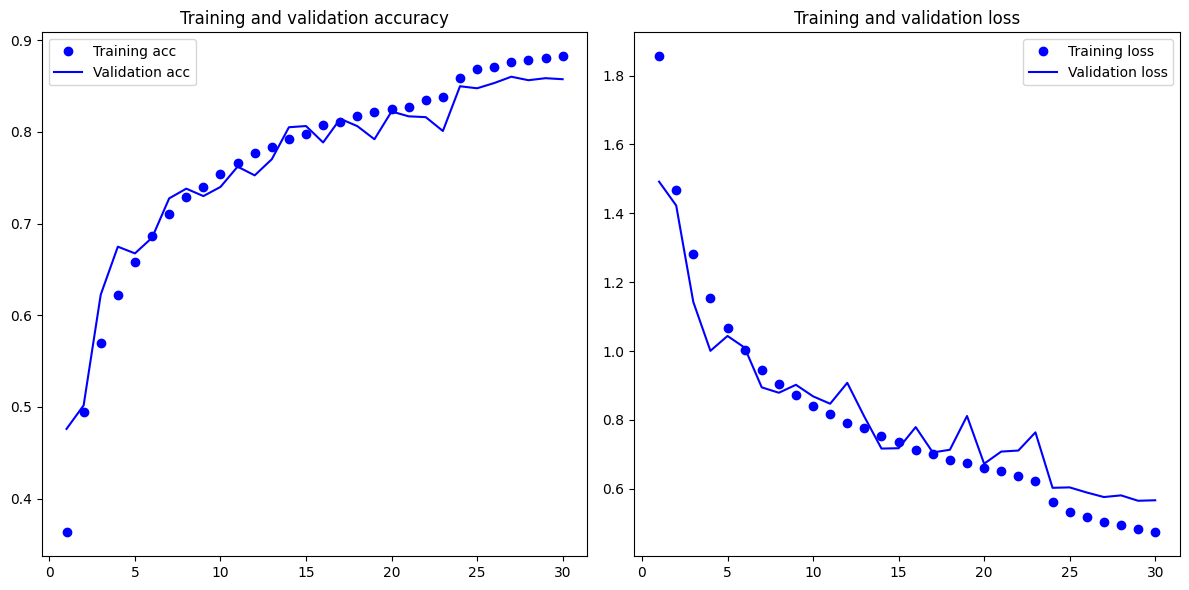

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.tight_layout()
plt.show()

- Analyzing the training and validation, accuracy and loss over the epochs:
    - We see that the model begins overfitting slightly after the **24th** epoch.
    - The validation accuracy stops improving significantly after the **26th** epoch while the training accuracy keeps improving.
    - The validation loss stops improving significantly after the **24th** epoch while the training loss keeps improving.
    - The best model, based on validation loss, is saved on the **29th** epoch.

---
#### Model Testing

In [11]:
test_labels = []
test_predictions = []
test_probabilities = []

for images, labels in test_dataset:
    test_labels.extend(labels.numpy())
    predictions = model.predict(images)
    test_predictions.extend(np.argmax(predictions, axis=-1))
    test_probabilities.extend(predictions)

test_labels = np.array(test_labels)
test_predictions = np.array(test_predictions)
test_probabilities = np.array(test_probabilities)

1/1 [==============================] - 0s 92ms/step


---
#### Confusion Matrix

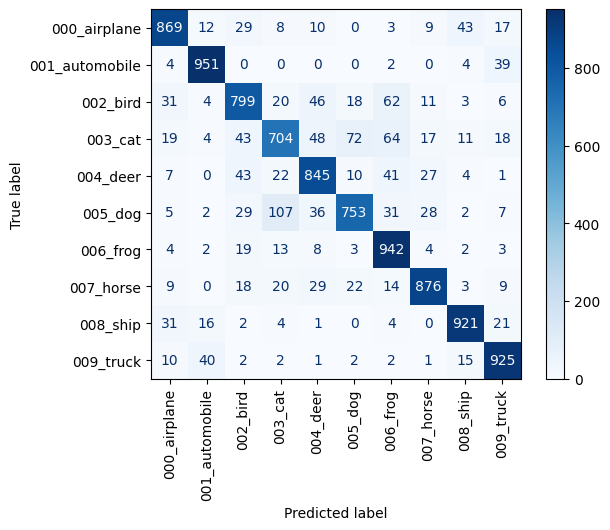

In [12]:
cm = confusion_matrix(test_labels, test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=90)
plt.show()

- Looking at the confusion matrix, we see that:  
    - The model still has a hard time distinguishing between the categories 003_cat and 005_dog but with less error.  
    - The model has a below average performance on the categories 003_cat, 005_dog and 002_bird, in which we see a very high false positive rate.
    - The model also has a hard time distinguishing between some other categories but the error is not as significant.  
    - The model has an above average performance on the categories 001_automobile, 006_frog, 008_ship and 009_truck.
    - The model has shown a performance increase with higher accuracy across all categories.

---
#### ROC Curve Analysis

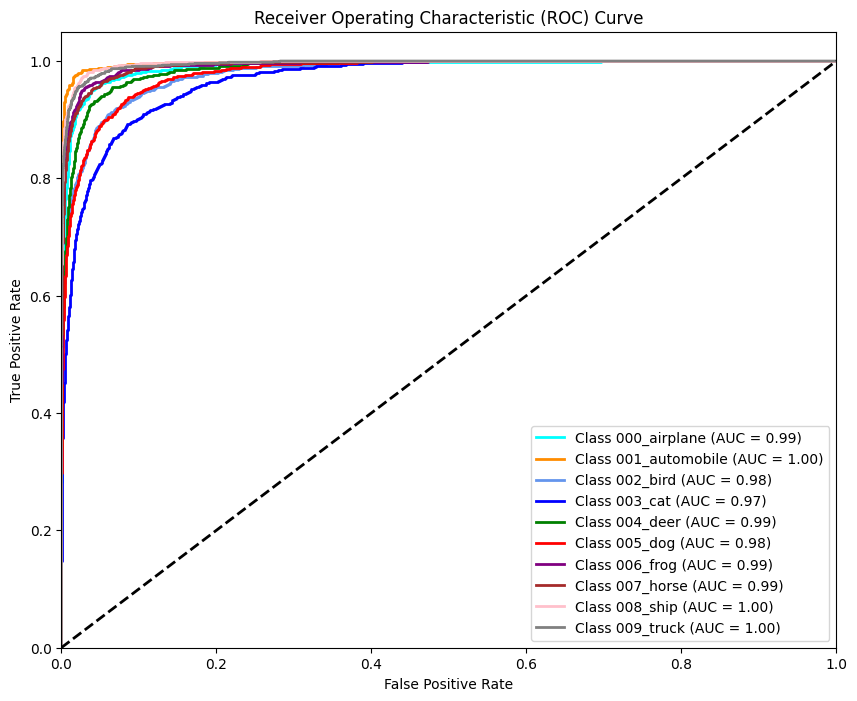

In [13]:
test_labels_bin = label_binarize(test_labels, classes=range(NUM_CLASSES))

false_positive_rate = dict()
true_positive_rate = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    false_positive_rate[i], true_positive_rate[i], _ = roc_curve(test_labels_bin[:, i], test_probabilities[:, i])
    roc_auc[i] = auc(false_positive_rate[i], true_positive_rate[i])

plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'blue', 'green', 'red', 'purple', 'brown', 'pink', 'grey'])
for i, color in zip(range(NUM_CLASSES), colors):
    plt.plot(false_positive_rate[i], true_positive_rate[i], color=color, lw=2, label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

- Looking at the ROC curve:
    - We see that the model has a good performance on the ROC curve for most categories.  
    - The categories 003_cat, 002_bird and 005_dog have the worst AUC (Area Under Curve) performance.
    - The other categories have the same performance but with higher AUC.
    - The category 001_automobile, 008_ship and 009_truck has the best AUC performance.
    - The overall AUC performance increases as the false positive rate decreases and the true positive rate increases.
    - **A perfect AUC of 1.0 would mean that the model classifies all images either true positives or true negatives**.

---
#### Performance Metrics
- **Accuracy** is the proportion of correctly predicted instances out of the total instances.  
- **Precision** is the ratio of true positive predictions to the total predicted positives. Macro precision calculates this for each class independently and then averages them.  
- **Weighted precision** calculates the precision for each class, then averages them, weighted by the number of true instances for each class.  
- **Recall** is the ratio of true positive predictions to the total actual positives. Macro recall calculates this for each class independently and then averages them.  
- **Weighted recall** calculates the recall for each class, then averages them, weighted by the number of true instances for each class.  
- The **F1-score** is the harmonic mean of precision and recall. Macro F1-score calculates this for each class independently and then averages them.  
- **Weighted F1-score** calculates the F1-score for each class, then averages them, weighted by the number of true instances for each class.

In [14]:
acc = accuracy_score(y_true =  test_labels, y_pred = test_predictions)
print(f'Accuracy : {np.round(acc*100,2)}%')
precision = precision_score(y_true =  test_labels, y_pred = test_predictions, average='macro')
print(f'Precision - Macro: {np.round(precision*100,2)}%')
recall = recall_score(y_true =  test_labels, y_pred = test_predictions, average='macro')
print(f'Recall - Macro: {np.round(recall*100,2)}%')
f1 = f1_score(y_true =  test_labels, y_pred = test_predictions, average='macro')
print(f'F1-score - Macro: {np.round(f1*100,2)}%')
precision = precision_score(y_true =  test_labels, y_pred = test_predictions, average='weighted')
print(f'Precision - Weighted: {np.round(precision*100,2)}%')
recall = recall_score(y_true =  test_labels, y_pred = test_predictions, average='weighted')
print(f'Recall - Weighted: {np.round(recall*100,2)}%')
f1 = f1_score(y_true =  test_labels, y_pred = test_predictions, average='weighted')
print(f'F1-score - Weighted: {np.round(f1*100,2)}%')

Accuracy : 85.85%
Precision - Macro: 85.83%
Recall - Macro: 85.85%
F1-score - Macro: 85.73%
Precision - Weighted: 85.83%
Recall - Weighted: 85.85%
F1-score - Weighted: 85.73%


- **Since the dataset is balanced, the MACRO average is a good metric to evaluate the model.**

# Conclusion
### Summary
- In this notebook:
    - We enhanced the architecture by:
        - We used L2 regularization.
    - We applied data augmentation techniques:
        - Random Horizontal Flip
        - Random Rotation
        - Random Zoom
        - Random Brightness
        - Random Contrast
    - We used the Adaptive Moment Estimation (Adam) optimizer with an initial learning rate of 0.001.
    - We kept the same 30 epochs with a batch size of 64.
    - We evaluated the model on the validation dataset:
        - Overfitting was observed after **24 epochs**, but the best model was saved at the **29th epoch**.
        - Training was intended for 30 epochs but stopped early due to the **Early Stopping** callback.
    - We evaluated the model on the test set.
        - We evaluated the model using a confusion matrix to analyze its performance on each category.
        - We evaluated the model using ROC curves for a deeper performance analysis.
        - The model achieved an accuracy of **85.85%** on the test set which was a good improvement.

### Future Work
- In the next notebook:
    - We will upscale the dataset images to 160 x 160.
    - We will use feature extraction with the VGG16 Convolutional Base to:
        - Extract the train dataset feature maps.
        - Extract the validation dataset feature maps.
    - We will then train a classifier model with those extracted feature maps.
    - We will keep the same 30 epochs with a batch size of 64.
    - We will then join the VGG16 Convolutional Base with the classifier model.
    - We will test the results on the test set.